In [422]:
import numpy as np
import matplotlib.pyplot as plt
import re
%matplotlib inline
num_cpu = 64
clientCPU = range(32,48)
serverCPU = range(16,31)
idle_times={}
for i in range(num_cpu):
    idle_times[i]=[]
    
outputfolder = "output_arm"
utilFile = outputfolder+"/util.txt"
operationsFile = outputfolder+"/operations.txt"
benchmarkFile = outputfolder+"/benchmark.txt"
with open(utilFile) as f:
    utilBigList = f.read().split("@")[1:]

for utilSingle in utilBigList:
    idle_times_temp = {}
    for i in range(num_cpu):
        idle_times_temp[i]=[]
    stringNewLine = utilSingle.split('\n')[2:]
    for stringLine in stringNewLine:        
        words = stringLine.split()
        if(len(words)>=2 and words[1].isdigit()):
            CPU = int(words[1])
            idle = float(words[-1].rstrip('\x00'))
            idle_times_temp[CPU].append(idle)
    for i in range(num_cpu):
        idle_times[i].append(idle_times_temp[i])
idle_times_avg = {}
for i in range(num_cpu):
    idle_times_avg[i]=[]
    for times in idle_times[i]:
        idle_times_avg[i].append(np.mean(times))
#print(idle_times_avg)

with open(operationsFile) as f:                                                                                                                                                                                     
    operationsStr = f.read().split('\n')[:-1]
operations = np.array(map(int, operationsStr))

def readBenchmark(benchmarkFile):
    readLatency95 = []
    updateLatency95 = []
    readLatency99 = []
    updateLatency99 = []
    readLatencyAvg = []
    updateLatencyAvg = []
    readOperations = []
    updateOperations = []
    throughput = []
    runTime = []
    with open(benchmarkFile) as f:
        lines = f.readlines()
        for line in lines:
    #         print(line)
            if re.search('\[READ\]\, 95thPercentileLatency\(us\)', line, re.I):
                readLatency95.append(float(line.split()[2]))
            if re.search('\[UPDATE\]\, 95thPercentileLatency\(us\)', line, re.I):
                updateLatency95.append(float(line.split()[2]))
            if re.search('\[READ\]\, 99thPercentileLatency\(us\)', line, re.I):
                readLatency99.append(float(line.split()[2]))
            if re.search('\[UPDATE\]\, 99thPercentileLatency\(us\)', line, re.I):
                updateLatency99.append(float(line.split()[2]))
            if re.search('\[READ\], Operations',line, re.I):
                readOperations.append(float(line.split()[2]))
            if re.search('\[UPDATE\], Operations',line, re.I):
                updateOperations.append(float(line.split()[2]))
            if re.search('\[OVERALL\], Throughput',line, re.I):
                throughput.append(float(line.split()[2]))
            if re.search('\[OVERALL\], RunTime',line, re.I):
                runTime.append(float(line.split()[2]))
            if re.search('\[UPDATE\], AverageLatency\(us\)',line, re.I):
                updateLatencyAvg.append(float(line.split()[2]))
            if re.search('\[READ\], AverageLatency\(us\)',line, re.I):
                readLatencyAvg.append(float(line.split()[2]))
            
    readLatency99 = np.array(readLatency99)
    updateLatency99 = np.array(updateLatency99)
    throughput = np.array(throughput)
    runTime = np.array(runTime)
    return {
        "readLatency95":readLatency95,
        "updateLatency95":updateLatency95,
        "readLatency99":readLatency99,
        "updateLatency99":updateLatency99,
        "readOperations":readOperations,
        "updateOperations":updateOperations,
        "updateLatencyAvg":updateLatencyAvg,
        "readLatencyAvg":readLatencyAvg,
        "throughput":throughput,
        "runTime":runTime
        
           
    }



for cpu in idle_times_avg:
    idle_times_avg[cpu] = np.array(idle_times_avg[cpu])
# idle_times_avg = np.array(idle_times_avg)?
# print(idle_times_avg[0])
   




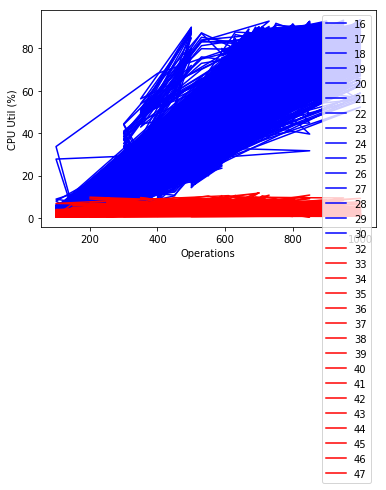

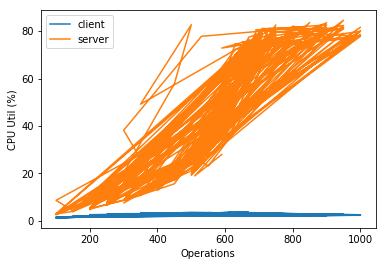

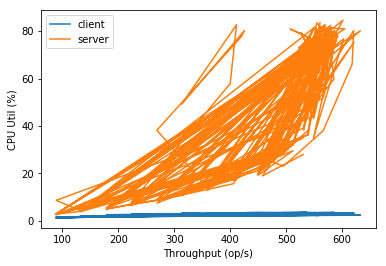

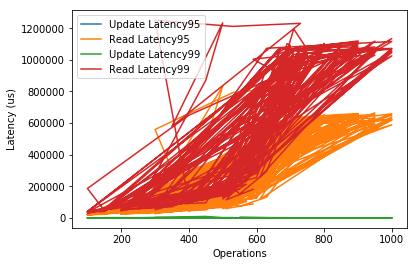

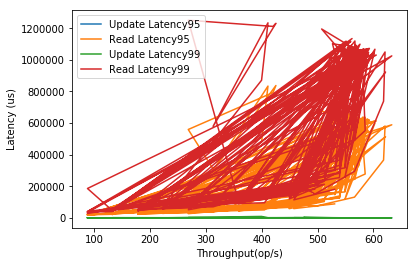

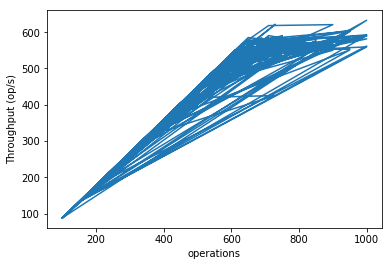

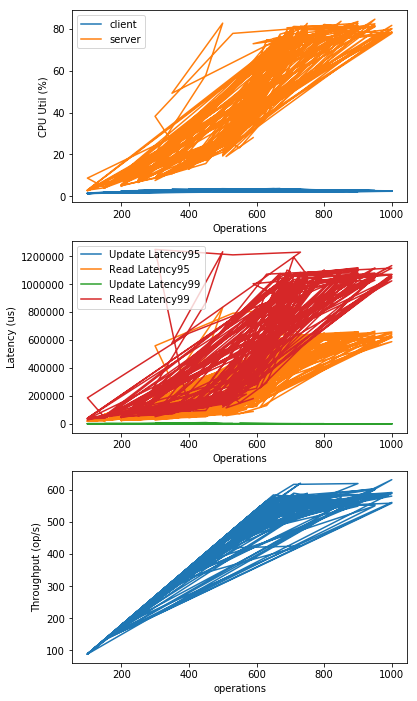

In [423]:
bench1 = readBenchmark(benchmarkFile)
#bench1 = readBenchmark("output/benchmark2.txt")
for i in idle_times_avg:
    idle_times_avg[i]=idle_times_avg[i][0:len(bench1["throughput"])]
operations = operations[:len(bench1["throughput"])]
util_bench = idle_times_avg[0]*0
util_server = idle_times_avg[0]*0
for i in range(num_cpu):
    if i in clientCPU:
        util_bench = util_bench + idle_times_avg[i]
    elif i in serverCPU:
        util_server = util_server + idle_times_avg[i]
util_bench = 100.0 - util_bench/len(clientCPU)
util_server = 100.0 - util_server/(len(serverCPU))
bench1["CPUUtilClient"] = util_bench
bench1["CPUUtilServer"] = util_server
# readLatency = bench1["readLatency"]
plt.figure(1)

for i in range(num_cpu):
    if(i in clientCPU):
        plt.plot(operations,100-np.array(idle_times_avg[i]),label=i,color='red')
        continue
    elif(i in serverCPU):
        plt.plot(operations,100-np.array(idle_times_avg[i]),label=i,color='blue')
plt.legend()
plt.xlabel("Operations")
plt.ylabel("CPU Util (%)")
plt.show()

plt.figure(2)
plt.plot(operations,util_bench,label="client")
plt.plot(operations,util_server,label="server")
plt.legend()
plt.xlabel("Operations")
plt.ylabel("CPU Util (%)")
plt.savefig("util.png")
plt.show()

plt.figure(2)
plt.plot(bench1["throughput"],util_bench,label="client")
plt.plot(bench1["throughput"],util_server,label="server")
plt.legend()
plt.xlabel("Throughput (op/s)")
plt.ylabel("CPU Util (%)")
plt.show()

plt.figure(3)
plt.plot(operations[0:len(bench1["updateLatency95"])],bench1["updateLatency95"],label="Update Latency95")
plt.plot(operations[0:len(bench1["updateLatency95"])],bench1["readLatency95"],label="Read Latency95")
plt.plot(operations[0:len(bench1["updateLatency99"])],bench1["updateLatency99"],label="Update Latency99")
plt.plot(operations[0:len(bench1["updateLatency99"])],bench1["readLatency99"],label="Read Latency99")
# plt.ylim(ymax=10000)
plt.legend()
plt.xlabel("Operations")
plt.ylabel("Latency (us)")
plt.savefig("latency.png")
plt.show()


plt.figure(3)
plt.plot(bench1["throughput"],bench1["updateLatency95"],label="Update Latency95")
plt.plot(bench1["throughput"],bench1["readLatency95"],label="Read Latency95")
plt.plot(bench1["throughput"],bench1["updateLatency99"],label="Update Latency99")
plt.plot(bench1["throughput"],bench1["readLatency99"],label="Read Latency99")
# plt.ylim(ymax=10000)
plt.legend()
plt.xlabel("Throughput(op/s)")
plt.ylabel("Latency (us)")
plt.savefig("throughput.png")
plt.show()

plt.figure()
plt.plot(operations[0:len(bench1["throughput"])],bench1["throughput"])
plt.xlabel("operations")
plt.ylabel("Throughput (op/s)")
# plt.savefig("throughput.png")
plt.show()

# plt.figure(4)
# plt.plot(bench1["throughput"],bench1["updateLatency95"],label="Update Latency95")
# plt.plot(bench1["throughput"],bench1["readLatency95"],label="Read Latency95")
# plt.plot(bench1["throughput"],bench1["updateLatency99"],label="Update Latency99")
# plt.plot(bench1["throughput"],bench1["readLatency99"],label="Read Latency99")

# plt.legend()
# plt.show()


# plt.figure(4)
# plt.plot(operations[:len(readOperations)],np.array(operations[:len(readOperations)])-(np.array(readOperations)+np.array(updateOperations)))
# plt.show()
fig = plt.figure()
(a,b) = fig.get_size_inches()
plt.figure(figsize=(a, b*3))
plt.subplot(3,1,1)
plt.plot(operations,util_bench,label="client")
plt.plot(operations,util_server,label="server")
plt.legend()
plt.xlabel("Operations")
plt.ylabel("CPU Util (%)")
plt.savefig("util.png")
# plt.show()


plt.subplot(3,1,2)
plt.plot(operations[0:len(bench1["updateLatency95"])],bench1["updateLatency95"],label="Update Latency95")
plt.plot(operations[0:len(bench1["updateLatency95"])],bench1["readLatency95"],label="Read Latency95")
plt.plot(operations[0:len(bench1["updateLatency99"])],bench1["updateLatency99"],label="Update Latency99")
plt.plot(operations[0:len(bench1["updateLatency99"])],bench1["readLatency99"],label="Read Latency99")
# plt.ylim(ymax=10000)
plt.legend()
plt.xlabel("Operations")
plt.ylabel("Latency (us)")
# plt.savefig("latency.png")
# plt.show()

plt.subplot(3,1,3)
plt.plot(operations[0:len(bench1["throughput"])],bench1["throughput"])
plt.xlabel("operations")
plt.ylabel("Throughput (op/s)")
plt.savefig("graphs.png")
plt.show()

In [426]:
values = ["updateLatency95","updateLatency99","updateLatencyAvg","readLatency95","readLatency99","readLatencyAvg","throughput","CPUUtilClient","CPUUtilServer","runTime"]
benchStdMean = {}
for value in values:
    benchStdMean[value] = []
operations = operations[0:len(bench1["updateLatency95"])]

unique_op={}
for i in range(len(operations)):
    if operations[i] not in unique_op:
        unique_op[operations[i]] = operations[i]
sorted_op = np.sort(unique_op.keys())
for op in sorted_op:
    ii = np.where(operations == op)[0]
    for value in values:
        benchStdMean[value].append(np.take(bench1[value],ii))
for value in values:
    benchStdMean[value+"Mean"] = []
    for x in benchStdMean[value]:
        benchStdMean[value+"Mean"].append(np.mean(x)) 
    benchStdMean[value+"Std"] = []
    for x in benchStdMean[value]:
        benchStdMean[value+"Std"].append(np.std(x)) 
for value in benchStdMean:
    benchStdMean[value]=np.array(benchStdMean[value])

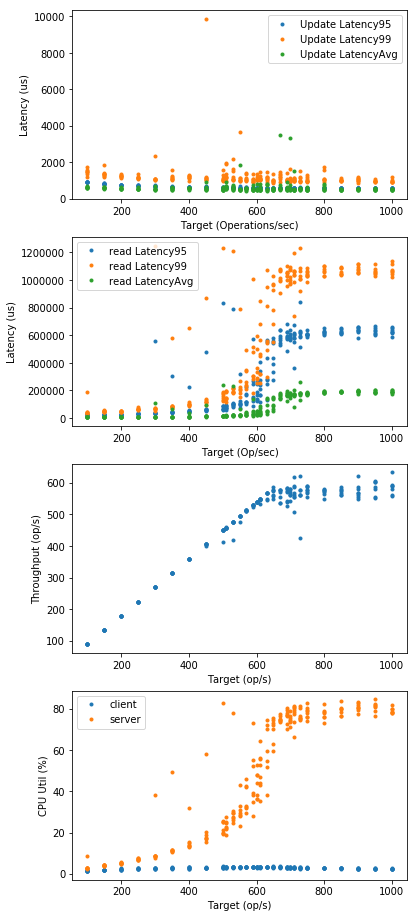

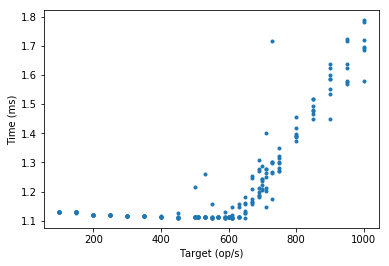

In [427]:
fig = plt.figure()
(a,b) = fig.get_size_inches()
plt.figure(figsize=(a, b*4))


plt.subplot(4,1,1)
plt.plot(operations[0:len(bench1["updateLatency95"])],bench1["updateLatency95"],label="Update Latency95",linestyle='None',marker=".")

plt.plot(operations[0:len(bench1["updateLatency99"])],bench1["updateLatency99"],label="Update Latency99",linestyle='None',marker=".")
plt.plot(operations[0:len(bench1["updateLatency99"])],bench1["updateLatencyAvg"],label="Update LatencyAvg",linestyle='None',marker=".")
plt.xlabel("Target (Operations/sec)")
plt.ylabel("Latency (us)")
plt.legend()

plt.subplot(4,1,2)
plt.plot(operations[0:len(bench1["readLatency95"])],bench1["readLatency95"],label="read Latency95",linestyle='None',marker=".")

plt.plot(operations[0:len(bench1["readLatency99"])],bench1["readLatency99"],label="read Latency99",linestyle='None',marker=".")
plt.plot(operations[0:len(bench1["readLatency99"])],bench1["readLatencyAvg"],label="read LatencyAvg",linestyle='None',marker=".")
plt.xlabel("Target (Op/sec)")
plt.ylabel("Latency (us)")
plt.legend()


plt.subplot(4,1,3)
plt.plot(operations,bench1["throughput"][0:len(operations)],linestyle='None',marker=".")
plt.xlabel("Target (op/s)")
plt.ylabel("Throughput (op/s)")


plt.subplot(4,1,4)
plt.plot(operations,util_bench,label="client",linestyle='None',marker=".")
plt.plot(operations,util_server,label="server",linestyle='None',marker=".")
plt.legend()
plt.xlabel("Target (op/s)")
plt.ylabel("CPU Util (%)")
plt.savefig("New_plot_target_throughput_ARM_lotsa_points.png")
plt.show()

plt.figure(1)
plt.plot(operations[0:len(bench1["readLatency99"])],bench1["runTime"]/1000/30,linestyle='None',marker=".")
plt.xlabel("Target (op/s)")
plt.ylabel("Time (ms)")
plt.show()



# fig = plt.figure()
# (a,b) = fig.get_size_inches()
# plt.figure(figsize=(a, b*4))


# plt.subplot(4,1,1)
# plt.plot(operations[0:len(bench1["updateLatency95"])],bench1["updateLatency95"],label="Update Latency95",linestyle='None',marker=".")

# plt.plot(operations[0:len(bench1["updateLatency99"])],bench1["updateLatency99"],label="Update Latency99",linestyle='None',marker=".")
# plt.plot(operations[0:len(bench1["updateLatency99"])],bench1["updateLatencyAvg"],label="Update LatencyAvg",linestyle='None',marker=".")
# plt.xlabel("Throughput (Operations/sec)")
# plt.ylabel("Latency (us)")
# plt.legend()

# plt.subplot(4,1,2)
# plt.plot(operations[0:len(bench1["readLatency95"])],bench1["readLatency95"],label="read Latency95",linestyle='None',marker=".")

# plt.plot(operations[0:len(bench1["readLatency99"])],bench1["readLatency99"],label="read Latency99",linestyle='None',marker=".")
# plt.plot(operations[0:len(bench1["readLatency99"])],bench1["readLatencyAvg"],label="read LatencyAvg",linestyle='None',marker=".")
# plt.xlabel("Throughput (Op/sec)")
# plt.ylabel("Latency (us)")
# plt.legend()


# plt.subplot(4,1,3)
# plt.plot(operations[0:len(operations)],operations,linestyle='None',marker=".")
# plt.xlabel("Target (op/s)")
# plt.ylabel("Throughput (op/s)")


# plt.subplot(4,1,4)
# plt.plot(operations,util_bench,label="client",linestyle='None',marker=".")
# plt.plot(operations,util_server,label="server",linestyle='None',marker=".")
# plt.legend()
# plt.xlabel("Throughput (op/s)")
# plt.ylabel("CPU Util (%)")
# # plt.savefig("New_plot_target_throughput_ARM.png")
# plt.show()


# plt.ylim(ymax=10000)

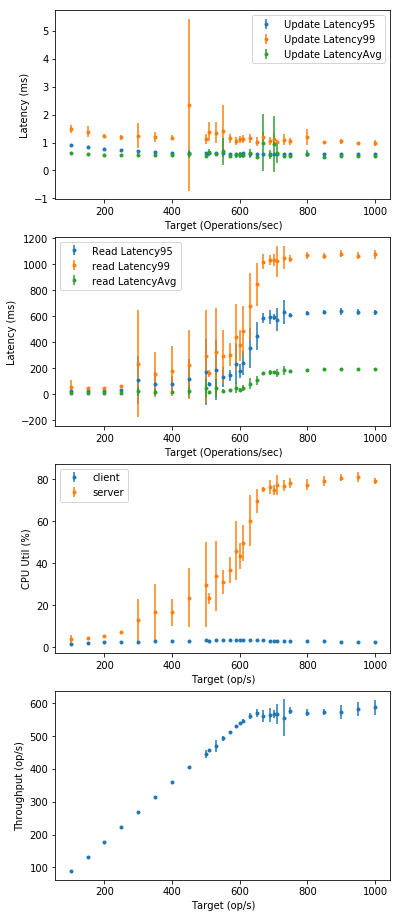

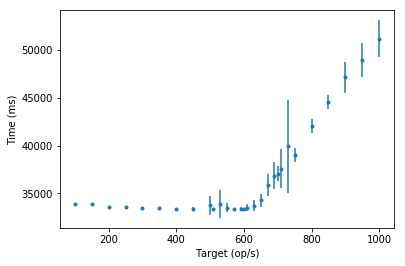

In [428]:

fig = plt.figure()
(a,b) = fig.get_size_inches()
plt.figure(figsize=(a, b*4))


plt.subplot(4,1,1)
plt.errorbar(sorted_op,benchStdMean["updateLatency95Mean"]/1000,yerr = benchStdMean["updateLatency95Std"]/1000,label="Update Latency95",linestyle='None',marker=".")
plt.errorbar(sorted_op,benchStdMean["updateLatency99Mean"]/1000,yerr = benchStdMean["updateLatency99Std"]/1000,label="Update Latency99",linestyle='None',marker=".")
plt.errorbar(sorted_op,benchStdMean["updateLatencyAvgMean"]/1000,yerr = benchStdMean["updateLatencyAvgStd"]/1000,label="Update LatencyAvg",linestyle='None',marker=".")
# plt.plot(operations[0:len(bench1["updateLatency99"])],bench1["updateLatency99"],label="Update Latency99",linestyle='None',marker=".")
# plt.plot(operations[0:len(bench1["updateLatency99"])],bench1["updateLatencyAvg"],label="Update LatencyAvg",linestyle='None',marker=".")
plt.xlabel("Target (Operations/sec)")
plt.ylabel("Latency (ms)")
plt.legend()


plt.subplot(4,1,2)
plt.errorbar(sorted_op,benchStdMean["readLatency95Mean"]/1000,yerr = benchStdMean["readLatency95Std"]/1000,label="Read Latency95",linestyle='None',marker=".")
plt.errorbar(sorted_op,benchStdMean["readLatency99Mean"]/1000,yerr = benchStdMean["readLatency99Std"]/1000,label="read Latency99",linestyle='None',marker=".")
plt.errorbar(sorted_op,benchStdMean["readLatencyAvgMean"]/1000,yerr = benchStdMean["readLatencyAvgStd"]/1000,label="read LatencyAvg",linestyle='None',marker=".")
plt.xlabel("Target (Operations/sec)")
plt.ylabel("Latency (ms)")
plt.legend()



plt.subplot(4,1,4)
plt.errorbar(sorted_op,benchStdMean["throughputMean"],yerr = benchStdMean["throughputStd"],label="Throughput",linestyle='None',marker=".")
plt.xlabel("Target (op/s)")
plt.ylabel("Throughput (op/s)")


plt.subplot(4,1,3)
plt.errorbar(sorted_op,benchStdMean["CPUUtilClientMean"],yerr = benchStdMean["CPUUtilClientStd"],label="client",linestyle='None',marker=".")
plt.errorbar(sorted_op,benchStdMean["CPUUtilServerMean"],yerr = benchStdMean["CPUUtilServerStd"],label="server",linestyle='None',marker=".")
plt.legend()
plt.xlabel("Target (op/s)")
plt.ylabel("CPU Util (%)")
plt.savefig("good_plot.png")
plt.show()

plt.figure(1)
plt.errorbar(sorted_op,benchStdMean["runTimeMean"],yerr = benchStdMean["runTimeStd"],linestyle='None',marker=".")
plt.xlabel("Target (op/s)")
plt.ylabel("Time (ms)")
plt.show()




In [429]:
print(len(operations))
print(len(sorted_op))
for op in sorted_op:
    print("{} : {}".format(op,np.count_nonzero(operations == op)))

211
29
100 : 7
150 : 8
200 : 7
250 : 7
300 : 7
350 : 7
400 : 7
450 : 7
500 : 8
510 : 7
530 : 8
550 : 7
570 : 7
590 : 7
600 : 7
610 : 8
630 : 7
650 : 7
670 : 7
690 : 8
700 : 7
710 : 8
730 : 7
750 : 8
800 : 7
850 : 7
900 : 8
950 : 7
1000 : 7


In [440]:
benchStdMean["readLatency99Mean"]
for i in range(len(sorted_op)):
    print("{}:{}".format(sorted_op[i],benchStdMean["readLatency99Mean"][i]/benchStdMean["updateLatency99Mean"][i]))
print("Avg")
for i in range(len(sorted_op)):
    print("{}:{}".format(sorted_op[i],benchStdMean["readLatencyAvgMean"][i]/benchStdMean["updateLatencyAvgMean"][i]))    


100:39.411429124
150:34.2437359677
200:39.6073243993
250:54.2996005326
300:190.531708444
350:128.56648299
400:151.041950389
450:96.5797707841
500:257.277156024
510:115.002984767
530:242.061245259
550:205.595817759
570:266.294675147
590:415.816788717
600:337.489479086
610:429.295539442
630:591.0659423
650:818.617292504
670:839.148793408
690:974.849469965
700:927.038362843
710:986.505489203
730:953.579992215
750:994.215281917
800:881.327476415
850:1051.60047982
900:1034.91091954
950:1097.36804124
1000:1096.24620991
Avg
100:9.68679087377
150:10.10527466
200:10.7513668282
250:13.5360072273
300:40.7150529558
350:31.5215698814
400:26.028518289
450:41.4496447763
500:83.9067654284
510:24.8786388068
530:78.7566262952
550:38.8846553614
570:53.557996168
590:89.7053126832
600:63.7969097774
610:85.5420482606
630:130.934419912
650:213.201300129
670:160.821279975
690:293.994658041
700:178.01337919
710:262.746181452
730:345.168849528
750:351.122398137
800:315.688077991
850:391.228207941
900:373.876072

In [397]:
benchStdMean["updateLatency95Mean"]

[905.39999999999998,
 829.60000000000002,
 758.0,
 721.0,
 670.60000000000002,
 655.39999999999998,
 636.0,
 619.20000000000005,
 608.60000000000002,
 615.60000000000002,
 618.60000000000002,
 602.39999999999998,
 607.79999999999995,
 599.39999999999998,
 599.60000000000002,
 607.0,
 594.0,
 593.39999999999998,
 602.20000000000005,
 591.5,
 591.60000000000002,
 585.0,
 588.79999999999995,
 590.16666666666663,
 600.39999999999998,
 593.20000000000005,
 592.20000000000005,
 588.60000000000002,
 582.20000000000005]